<a href="https://colab.research.google.com/github/Valeriy1990/Neural_networks/blob/main/PassiveAggressiveClassifier_and__XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import itertools
import plotly.graph_objects as go
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib.pyplot import figure

import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
!wget https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data

--2025-08-08 14:18:00--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘fake_news.csv’

fake_news.csv       100%[===================>]  29.27M  9.50MB/s    in 4.2s    

2025-08-08 14:18:06 (6.93 MB/s) - ‘fake_news.csv’ saved [30696129/30696129]

--2025-08-08 14:18:06--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40697 (40K) [application/x-www-form-urlencoded]
Saving to: ‘parkinsons.data’

parkinsons.data     100%[=====

# Построить модель классического машинного обучения, которая может с высокой точностью более 90% определять, является ли новость реальной (REAL） или фальшивой（FAKE).

In [ ]:
df = pd.read_csv(f'/content/fake_news.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df['text'], df.label, test_size=0.2, random_state=10)

tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train=tfidf_vectorizer.fit_transform(X_train)
tfidf_test=tfidf_vectorizer.transform(X_test)

pac=PassiveAggressiveClassifier(max_iter=30)

pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=30)

In [ ]:
y_pred=pac.predict(tfidf_test)

score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')


fig = go.Figure(data=[go.Bar(
            x=['Real','Fake'], y=df.label.value_counts(),
            text=df.label.value_counts(),
            textposition='auto',
        )])

fig.show()


Accuracy: 94.63%


In [ ]:
confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Прогнозируемый Fake', 'Прогнозируемый Real'],
             index=['Истинный Fake', 'Истинный Real'])

,Прогнозируемый Fake,Прогнозируемый Real
Истинный Fake,573,30
Истинный Real,38,626


In [ ]:
print('\n clasification report:\n\n',classification_report(y_test,y_pred))


 clasification report:

               precision    recall  f1-score   support

        FAKE       0.94      0.95      0.94       603
        REAL       0.95      0.94      0.95       664

    accuracy                           0.95      1267
   macro avg       0.95      0.95      0.95      1267
weighted avg       0.95      0.95      0.95      1267



# Предсказать заболевание паркинсона на ранней стадии, используя алгоритм машинного обучения XGBoost и библиотеку sklearn для нормализации признаков.

In [ ]:
df = pd.read_csv(f"/content/parkinsons.data", sep=',')

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


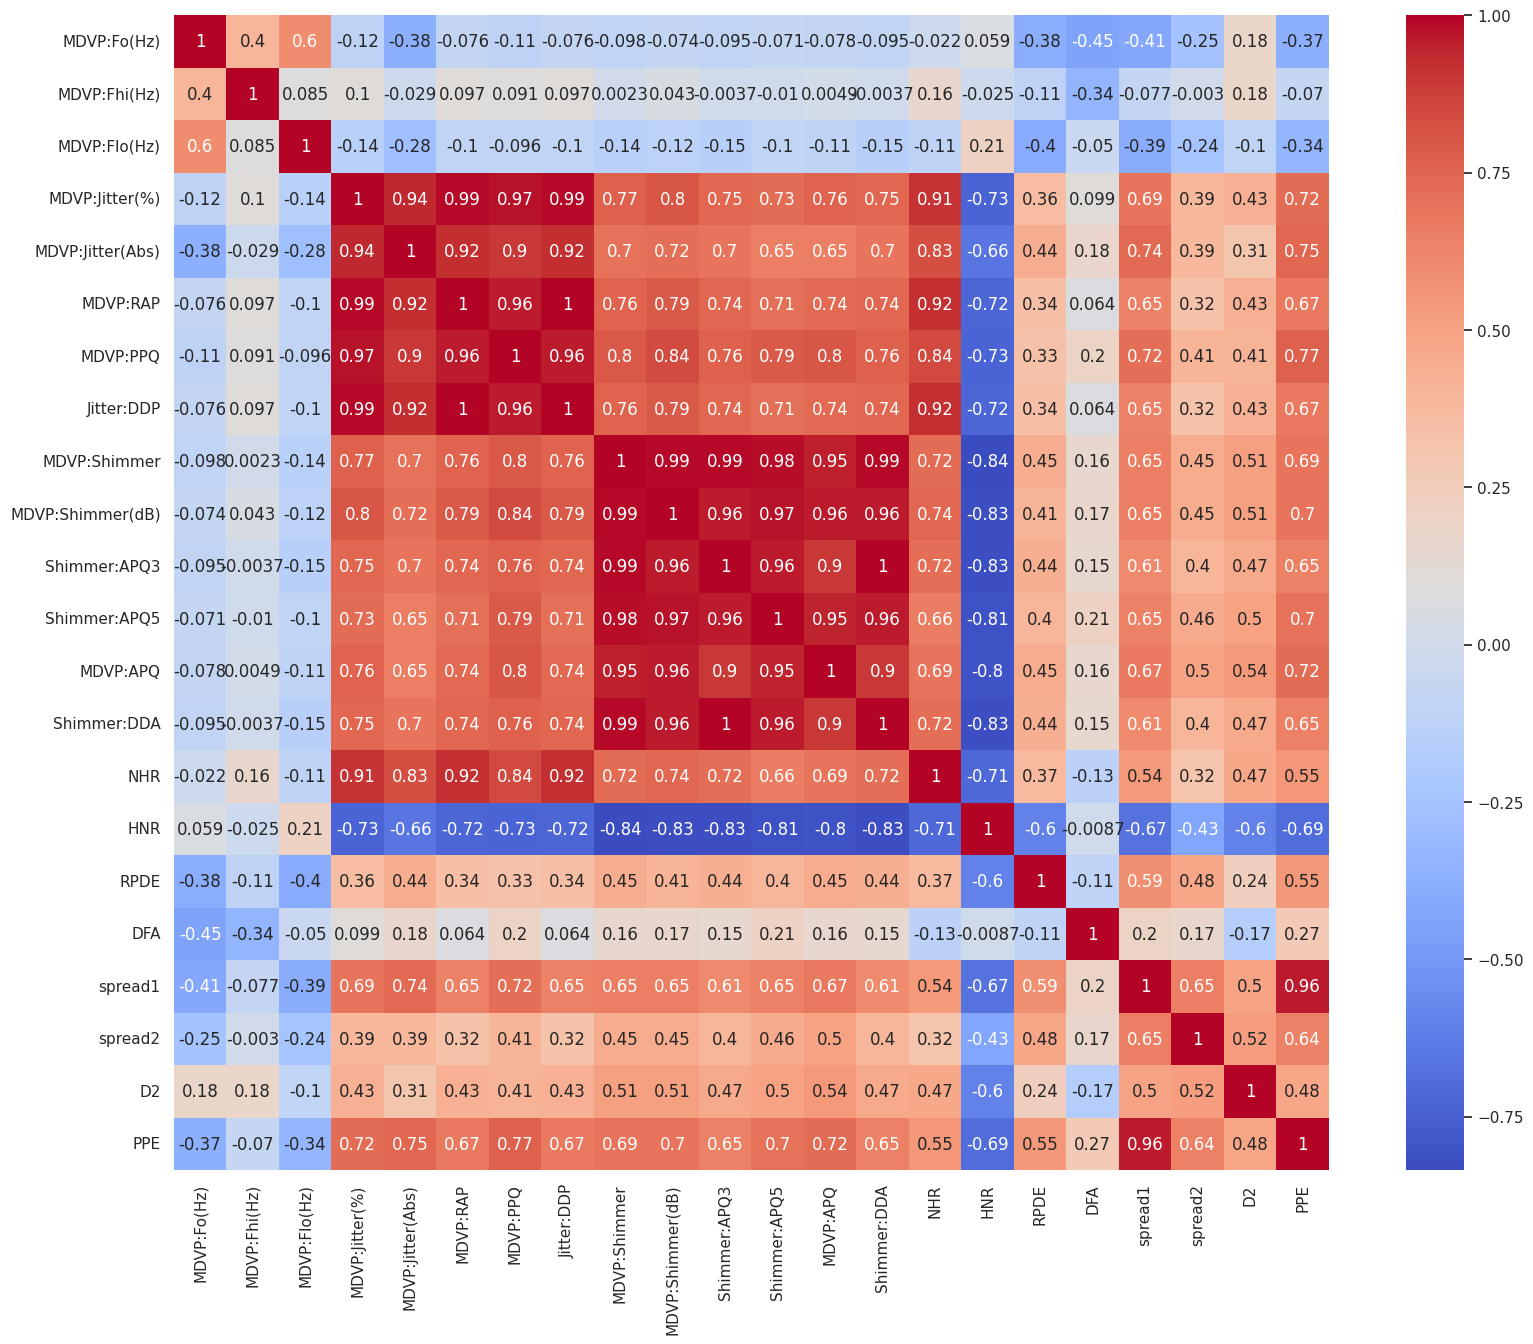

In [ ]:
sns.set(rc={'figure.figsize': (20, 15)})
features = df.drop(['status', 'name'], axis=1).columns  # Проверим какие признаки коррелируют между собой


f,ax = plt.subplots(1,1)
sns.heatmap(df[features].corr(), annot=True, square=True, cmap='coolwarm')

plt.show()
plt.close()

In [ ]:
    # n_estimators — число деревьев.
    # eta — размер шага. Предотвращает переобучение.
    # gamma — минимальное изменение значения loss функции для разделения листа на поддеревья.
    # max_depth — максимальная глубина дерева.
    # lambda/alpha — L2/L1 регуляризация.

X_train,X_test,y_train,y_test=train_test_split(df.drop(['status', 'name'], axis=1), df.status, test_size=0.2, random_state=7)

bst = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1, objective='binary:logistic')


scaler = StandardScaler() # Приводим числовые призноки к одной шкале
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

bst.fit(X_train_scaler, y_train)

print(*["ИстЗначений: " + str(bool(k)) + ' -> ' + str(v) for k,v in Counter(y_test).items()], sep='\n')
print()
y_pred = bst.predict(X_test_scaler)

score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print()
print(classification_report(y_test,y_pred))
print()
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Прогнозируемое отсутствие заболевания', 'Прогнозируемый синдром Паркинсона'],
             index=['Истинное отсутствие заболевания', 'Истинный синдром Паркинсона'])



ИстЗначений: False -> 7
ИстЗначений: True -> 32

Accuracy: 92.31%

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.94      0.97      0.95        32

    accuracy                           0.92        39
   macro avg       0.89      0.84      0.86        39
weighted avg       0.92      0.92      0.92        39




,Прогнозируемое отсутствие заболевания,Прогнозируемый синдром Паркинсона
Истинное отсутствие заболевания,5,2
Истинный синдром Паркинсона,1,31


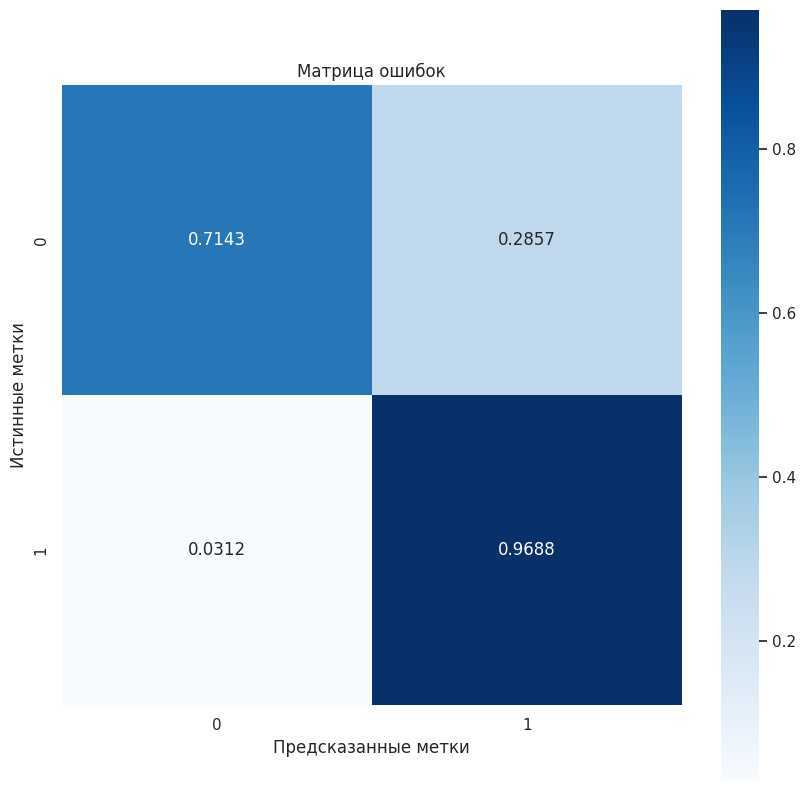

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Вычисление матрицы ошибок и ее нормализация
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels,
                                          test_classes)
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Матрица ошибок")
  plt.ylabel("Истинные метки")
  plt.xlabel("Предсказанные метки")

show_confusion_matrix(y_test, y_pred)

<Axes: >

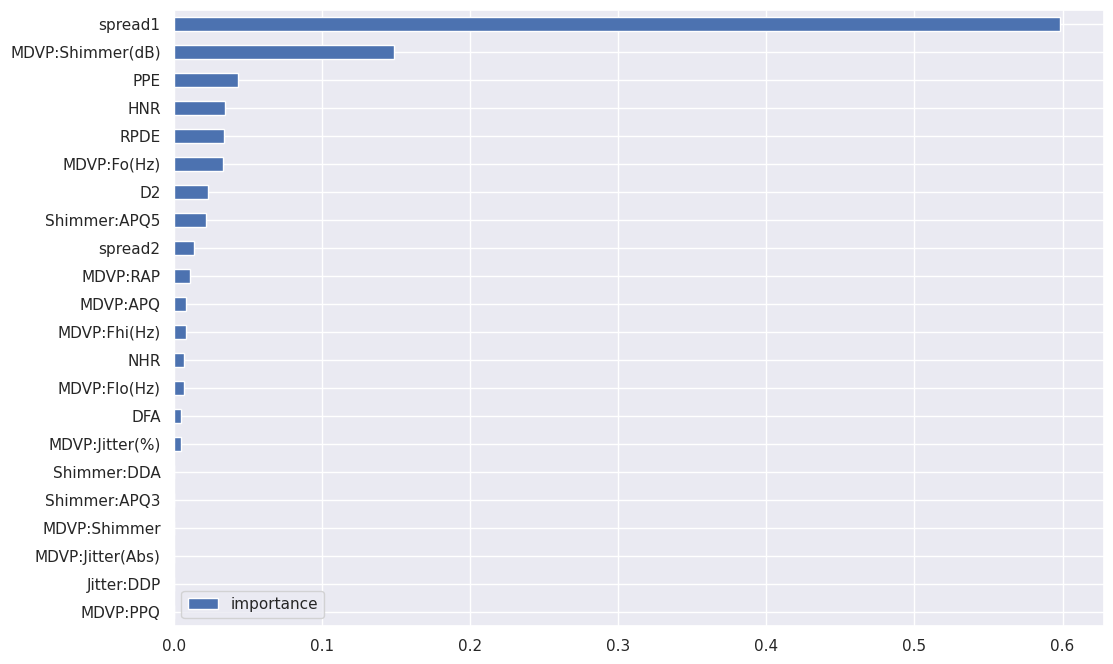

In [ ]:
imp = pd.DataFrame(bst.feature_importances_, index=X_train.columns, columns=['importance'])  # Графическое представление вжности фичей
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
df_new = df[['PPE', 'Shimmer:APQ5', 'MDVP:Jitter(Abs)', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'spread1', 'D2']] # Уберём лишние фичи

# Spread1 и PPE сильно коррелируют между собой. Судя по диаграме Spread1 имеет самый большой importance, но если его оставить в выборке точность

print(*["ИстЗначений: " + str(bool(k)) + ' -> ' + str(v) for k,v in Counter(y_test).items()], sep='\n')
print()

ИстЗначений: False -> 7
ИстЗначений: True -> 32



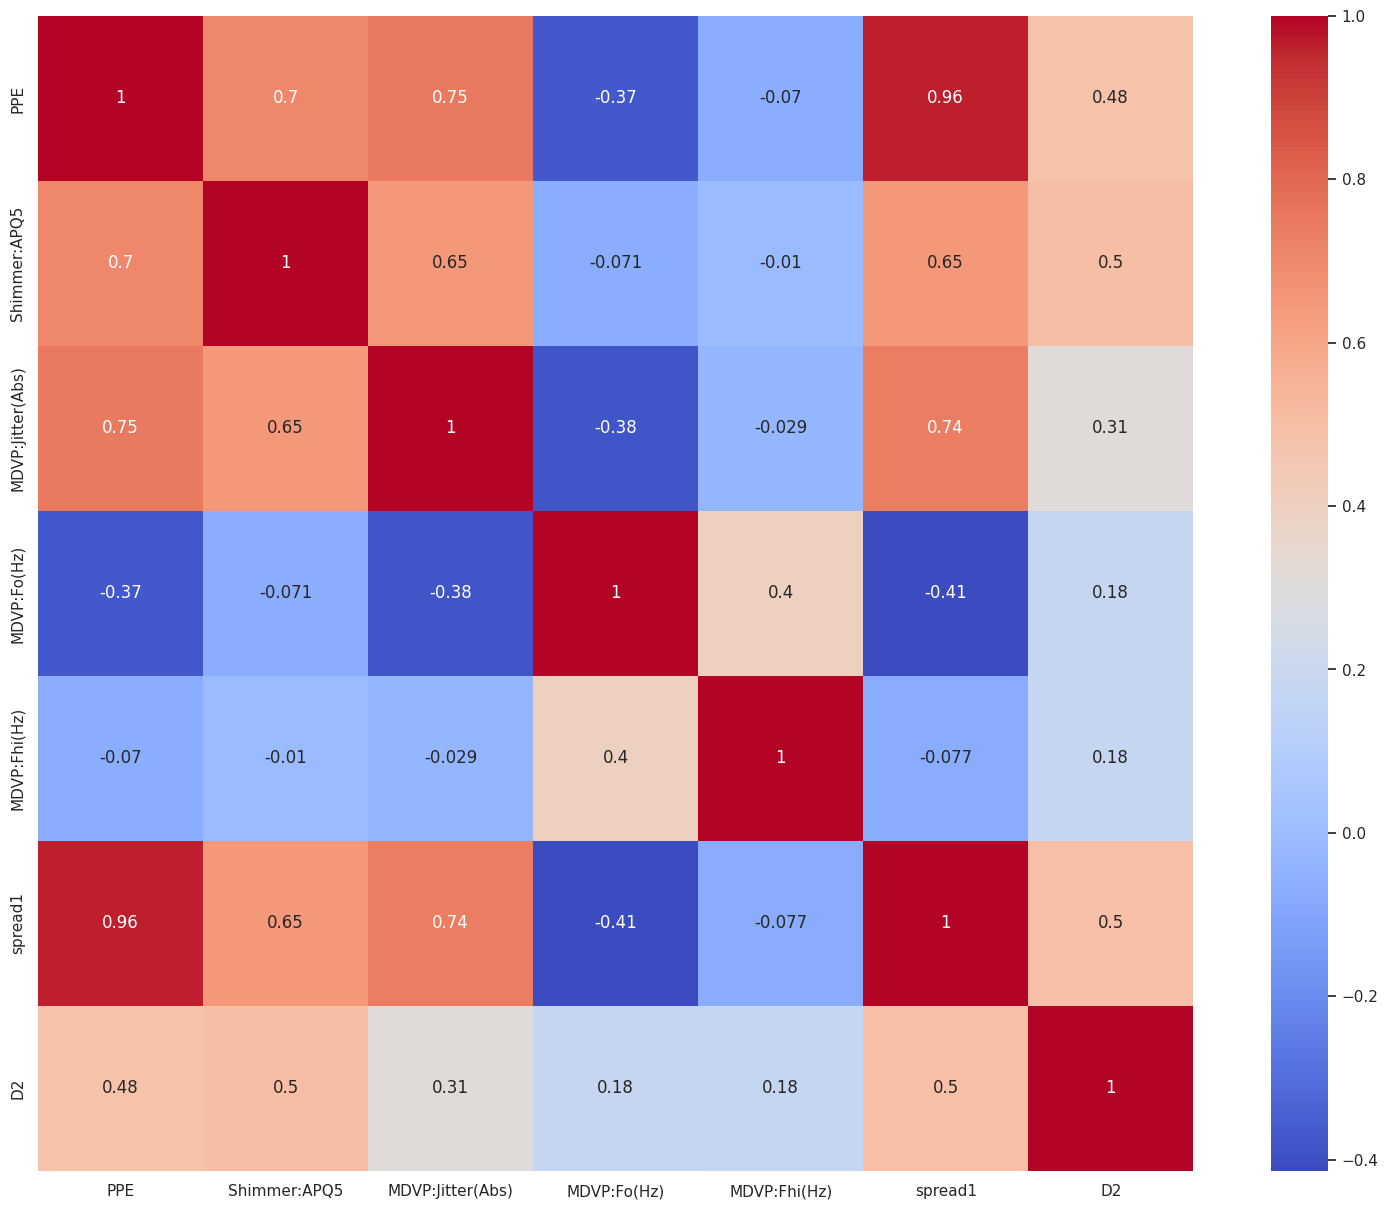

In [ ]:
features = df_new.columns

f,ax = plt.subplots(1,1)
sns.heatmap(df_new.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()
plt.close()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df_new, df.status, test_size=0.2, random_state=10)  # Подобрал подходящий random_state и n_estimators

bst = XGBClassifier(n_estimators=4, max_depth=3, learning_rate=1, objective='binary:logistic')

scaler = StandardScaler() # Приводим числовые призноки к одной шкале
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

bst.fit(X_train_scaler, y_train)

y_pred = bst.predict(X_test_scaler)

print(*["ИстЗначений: " + str(bool(k)) + ' -> ' + str(v) for k,v in Counter(y_test).items()], sep='\n')
print()

score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print()
print(classification_report(y_test,y_pred))
print()
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Прогнозируемое отсутствие заболевания', 'Прогнозируемый синдром Паркинсона'],
             index=['Истинное отсутствие заболевания', 'Истинный синдром Паркинсона'])

ИстЗначений: True -> 28
ИстЗначений: False -> 11

Accuracy: 97.44%

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.96      0.98        28

    accuracy                           0.97        39
   macro avg       0.96      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39




,Прогнозируемое отсутствие заболевания,Прогнозируемый синдром Паркинсона
Истинное отсутствие заболевания,11,0
Истинный синдром Паркинсона,1,27


In [ ]:
df_new = df[['PPE', 'Shimmer:APQ5', 'MDVP:Jitter(Abs)', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'D2']] # Уберём лишние фичи

"""Spread1 и PPE сильно коррелируют между собой. Судя по диаграме Spread1 имеет самый большой importance, но если его убрать
   из выборки точность поднимается до 100%"""

X_train,X_test,y_train,y_test=train_test_split(df_new, df.status, test_size=0.2, random_state=10)  # Подобрал подходящий random_state и n_estimators

bst = XGBClassifier(n_estimators=3, max_depth=3, learning_rate=1, objective='binary:logistic')

bst.fit(X_train, y_train)
print(*["ИстЗначений: " + str(bool(k)) + ' -> ' + str(v) for k,v in Counter(y_test).items()], sep='\n')
print()

y_pred = bst.predict(X_test)

score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print()
print(classification_report(y_test,y_pred))
print()
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Прогнозируемое отсутствие заболевания', 'Прогнозируемый синдром Паркинсона'],
             index=['Истинное отсутствие заболевания', 'Истинный синдром Паркинсона'])

ИстЗначений: True -> 28
ИстЗначений: False -> 11

Accuracy: 100.0%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        28

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39




,Прогнозируемое отсутствие заболевания,Прогнозируемый синдром Паркинсона
Истинное отсутствие заболевания,11,0
Истинный синдром Паркинсона,0,28
